# BoTorch Tutorials

_Drew Gjerstad_

**Includes content from BoTorch's [documentation](https://botorch.org/docs/) and
[tutorials](https://botorch.org/docs/tutorials/).**

This notebook contains tutorials showing how to use BoTorch effectively. The
tutorials in this notebook are list (and linked) below, organized in the same
manner as on BoTorch's site. Note that while the links work in Visual Studio
Code, there have been issues reported in GitHub Preview and popular viewing
tools like `nbviewer`.

## Contents

[**Full Optimization Loops**](#full-optimization-loops)

 * [High-Dimensional Bayesian Optimization with SAASBO](#high-dimensional-bayesian-optimization-with-saasbo)

[**Bite-Sized Tutorials**](#bite-sized-tutorials)

 * [Implementing Custom Acquisition Functions](#implementing-custom-acquisition-functions)

[**Advanced Usage**](#advanced-usage)

## Full Optimization Loops
The tutorials in this section are focused on defining entire optimization loops
using BoTorch.

### High-Dimensional Bayesian Optimization with SAASBO
[_Link to Tutorial on BoTorch_](https://botorch.org/docs/tutorials/saasbo/)

In this tutorial, we review how to implement **Sparse Axis-Aligned Subspace**
**Bayesian Optimization**
([SAASBO](https://proceedings.mlr.press/v161/eriksson21a.html)) for
high-dimensional Bayesian optimization. The SAASBO method avoids the
over-fitting in high-dimensional spaces by placing strong priors on the inverse
lengthscales. In particular, SAASBO makes use of a hierarchical sparsity prior
incorporating a global shrinkage parameter $\tau\sim\mathcal{HC}(\beta)$ and
inverse lengthscales $\rho_{d}\sim\mathcal{HC}(\tau)$ for $d=1,\dots,D$ where
$\mathcal{HC}$ denotes the half-Cauchy distribution. While the half-Cauchy
distribution favors values near zero, they also have heavy tails that help the
inverse lengthscales for the most important parameters to avoid zero.

The tutorial's author notes that for performing inference in the SAAS model we
will use Hamiltonian Monte Carlo (HMC) as it was found to outperform MAP
inference. In addition, SAASBO performs well for problems with hundreds of
dimensions but since we are relying on HMC for inference, SAASBO's overhead
scales cubically with the number of samples. Thus, depending on the problem,
using more than a few hundred samples may be infeasible due to SAASBO's design
being advantageous for problems with limited evaluation budget.

In [4]:
# Load Dependencies
import sys
import os

import torch
from torch.quasirandom import SobolEngine

from botorch import fit_fully_bayesian_model_nuts
from botorch.acquisition.logei import qLogExpectedImprovement
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf
from botorch.test_functions import Branin

SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [5]:
# Define Tensor Keyword Arguments
tkwargs = {
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "dtype": torch.double
}

To avoid increased overhead and decrease the time it takes to fit the SAAS model
by lowering `WARMUP_STEPS` and `NUM_SAMPLES`. The author recommends using 512
warmup steps and 256 samples when possible and avoid using less than 256 warmup
steps and 128 samples. The default practice is to only keep each 16th sample
meaning for 256 samples results in 32 hyperparameter samples (this is controlled
via the `THINNING` variable below).

To keep this tutorial efficient, the author uses 256 warmup steps and 128
samples.

In [6]:
WARMUP_STEPS = 256 if not SMOKE_TEST else 32
NUM_SAMPLES = 128 if not SMOKE_TEST else 16
THINNING = 16

Next, we start by reviewing how to fit a simple model. To do this, we generate
a simple function that is only dependent on the first parameter to demonstrate
that the SAAS model sets all other lengthscales to large values.

In [7]:
# Generate Simple Function
train_X = torch.rand(10, 4, **tkwargs)
test_X = torch.rand(5, 4, **tkwargs)
train_Y = torch.sin(train_X[:, :1])
test_Y = torch.sin(test_X[:, :1])

Typically, we will infer the _unknown_ noise variance in the data. However, we
can specify the known noise variant (`train_Yvar`) for each observation. This is
particularly useful if we know that the problem is noise-free and we can set the
noise variant to a small value such as `1e-6`. Then, we can construct a model
for this case as shown in the next code cell.

In [9]:
# Construct GP Model (known noise variant)
gp = SaasFullyBayesianSingleTaskGP(train_X=train_X,
                                   train_Y=train_Y,
                                   train_Yvar=torch.full_like(train_Y, 1e-6))

In the next code cell, we define the model for this tutorial and example.

In [10]:
# Construct GP Model
gp = SaasFullyBayesianSingleTaskGP(train_X=train_X,
                                   train_Y=train_Y,
                                   outcome_transform=Standardize(m=1))

fit_fully_bayesian_model_nuts(
    gp,
    warmup_steps=WARMUP_STEPS,
    num_samples=NUM_SAMPLES,
    thinning=THINNING,
    disable_progbar=True,
)

with torch.no_grad():
    posterior = gp.posterior(test_X)

To show that the first feature has the smallest lengthscale, we can compute the
median lengthscales over the MCMC dimensions.

In [11]:
print(gp.median_lengthscale.detach())

tensor([ 2.3037, 12.0275, 38.1321, 18.8247], dtype=torch.float64)


Now that the model is trained, we can use it to make predictions. In the cell
below, we make predictions with the SAAS model in the same fashion as other
posteriors in BoTorch: computing the mean and variance for test points. Note
that the mean and posterior tensors have an extra batch dimension at -3
corresponding to the number of MCMC samples (8 in this tutorial).

In [12]:
# Print Dimensions of Posterior Mean and Variance
print(posterior.mean.shape)
print(posterior.variance.shape)

torch.Size([8, 5, 1])
torch.Size([8, 5, 1])


Additionally, BoTorch also provides methods to easily compute different
statistics across the MCMC samples, as shown below.

In [15]:
# Compute Statistics over MCMC Samples
mixture_mean = posterior.mixture_mean
mixture_variance = posterior.mixture_variance
mixture_quantile = posterior.quantile(torch.tensor(0.95))

print(f"Ground Truth:   {test_Y.squeeze(-1)}")
print(f"Mixture Mean:   {mixture_mean.squeeze(-1)}")

Ground Truth:   tensor([0.2099, 0.5055, 0.2166, 0.7694, 0.1876], dtype=torch.float64)
Mixture Mean:   tensor([0.2068, 0.5038, 0.2135, 0.7700, 0.1871], dtype=torch.float64)


Since we have an understanding of how to implement SAASBO using BoTorch, we can
apply the method to optimize Branin embedded in a 30-dimensional space.
Specifically, we embed the standard two-dimensional Branin problem in a
30-dimensional space with dimensions 0 and 1 corresponding to the true
dimensions. This exercise demonstrates that SAASBO can identify the critical
dimensions and optimize this function efficiently. Note that we will work with
the domain $[0,1]^d$ and unnormalize the inputs to true domain of Branin before
we evaluate the function.

In [19]:
# Prepare Branin Problem
branin = Branin().to(**tkwargs)

def branin_emb(x):
    """x is assumed to be in [0, 1]^d"""
    lb, ub = branin.bounds
    return branin(lb + (ub - lb) * x[..., :2])

In the next cell, we define the dimensions and evaluation budget.

In [17]:
# Define Problem Dimensions
DIM = 30 if not SMOKE_TEST else 2

# Define Evaluation Budget
N_INIT = 10
N_ITERATIONS = 8 if not SMOKE_TEST else 1
BATCH_SIZE = 5 if not SMOKE_TEST else 1
print(f"Using a total of {N_INIT + BATCH_SIZE * N_ITERATIONS} function evaluations")

Using a total of 50 function evaluations


We can now run the optimization with 10 initial Sobol (a type of sampling)
points and then 8 iterations of Bayesian optimization using the batch size of 5
defined above, resulting in a total of 50 function evaluations. Note that we
will flip the sign of the function values before fitting the SAAS model since
our focus is minimizing Branin. This is due to the fact that in BoTorch, the
acquisition functions assume maximization.

In [20]:
X = SobolEngine(dimension=DIM, scramble=True, seed=0).draw(N_INIT).to(**tkwargs)
Y = branin_emb(X).unsqueeze(-1)
print(f"Best initial point: {Y.min().item():.3f}")

for i in range(N_ITERATIONS):
    train_Y = -1 * Y  # Flip sign to minimize the function
    gp = SaasFullyBayesianSingleTaskGP(
        train_X=X,
        train_Y=train_Y,
        train_Yvar=torch.full_like(train_Y, 1e-6),
        outcome_transform=Standardize(m=1),
    )
    fit_fully_bayesian_model_nuts(
        gp,
        warmup_steps=WARMUP_STEPS,
        num_samples=NUM_SAMPLES,
        thinning=THINNING,
        disable_progbar=True,
    )

    # Use the Batch Log Expected Improvement (EI) Acquisition Function
    EI = qLogExpectedImprovement(model=gp, best_f=train_Y.max())
    candidates, acq_values = optimize_acqf(
        EI,
        bounds=torch.cat((torch.zeros(1, DIM), torch.ones(1, DIM))),
        q=BATCH_SIZE,
        num_restarts=10,
        raw_samples=1024,
    )

    # Get Next Set of Function Evaluations
    Y_next = torch.cat([branin_emb(x).unsqueeze(-1) for x in candidates]).unsqueeze(-1)
    if Y_next.min() < Y.min():
        ind_best = Y_next.argmin()
        x0, x1 = candidates[ind_best, :2].tolist()
        print(
            f"{i+1}) New Best: {Y_next[ind_best].item():.3f} @"
            f"[{x0:.3f}, {x1:.3f}]"
        )
    X = torch.cat((X, candidates))
    Y = torch.cat((Y, Y_next))

Best initial point: 5.322
3) New Best: 1.987 @[1.000, 0.214]
5) New Best: 0.440 @[0.120, 0.816]
6) New Best: 0.438 @[0.956, 0.167]
8) New Best: 0.405 @[0.121, 0.822]


From the output above, we were able to get relatively close to the global
optimum of $\approx 0.398$ after only 50 function evaluations. However, it is
best practice to plot these results to see how optimization progressed across
the iterations in the evaluation budget.

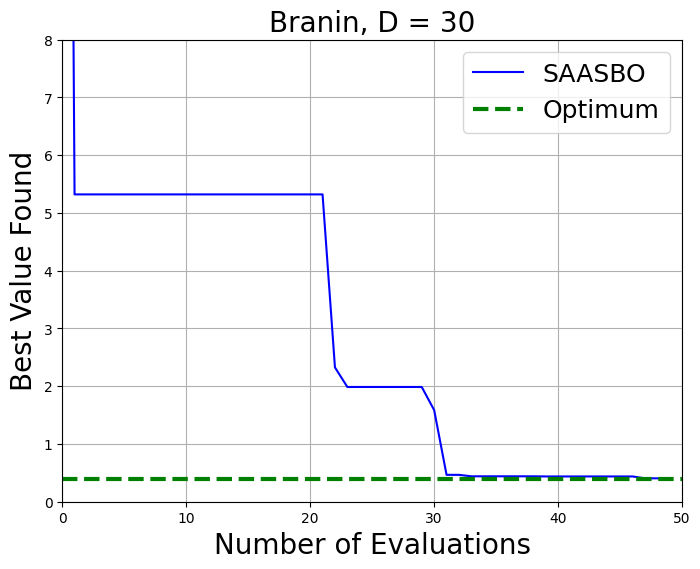

In [21]:
# Plot Results
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Y_np = Y.cpu().numpy()
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.minimum.accumulate(Y_np), color="b", label="SAASBO")
ax.plot([0, len(Y_np)], [0.398, 0.398], "--", c="g", lw=3, label="Optimum")
ax.grid(True)
ax.set_title(f"Branin, D = {DIM}", fontsize=20)
ax.set_xlabel("Number of Evaluations", fontsize=20)
ax.set_xlim([0, len(Y_np)])
ax.set_ylabel("Best Value Found", fontsize=20)
ax.set_ylim([0, 8])
ax.legend(fontsize=18)
plt.show()

Below, we will refit the model on 50 points and then predict 50 test points to
determine how well the SAAS model predicts out-of-sample points. Additionally,
we will also plot these predictions against their true values in addition to a
95% confidence interval for each test point.

In [22]:
# Initialize New Dataset for Training and Testing
train_X = SobolEngine(dimension=DIM, scramble=True, seed=0).draw(50).to(**tkwargs)
test_X = SobolEngine(dimension=DIM, scramble=True, seed=1).draw(50).to(**tkwargs)
train_Y = branin_emb(train_X).unsqueeze(-1)
test_Y = branin_emb(test_X).unsqueeze(-1)

# Define GP Model
gp = SaasFullyBayesianSingleTaskGP(
    train_X=train_X,
    train_Y=train_Y,
    train_Yvar=torch.full_like(train_Y, 1e-6),
    outcome_transform=Standardize(m=1),
)

# Fit Bayesian Model Using No-U-Turn-Sampler (NUTS)
fit_fully_bayesian_model_nuts(
    gp,
    warmup_steps=WARMUP_STEPS,
    num_samples=NUM_SAMPLES,
    thinning=THINNING,
    disable_progbar=True,
)

In [23]:
# Compute Posterior Distribution
with torch.no_grad():
    posterior = gp.posterior(test_X)

# Compute Quantiles for Points and their CIs
median = posterior.quantile(value=torch.tensor([0.5], **tkwargs))
q1 = posterior.quantile(value=torch.tensor([0.025], **tkwargs))
q2 = posterior.quantile(value=torch.tensor([0.975], **tkwargs))

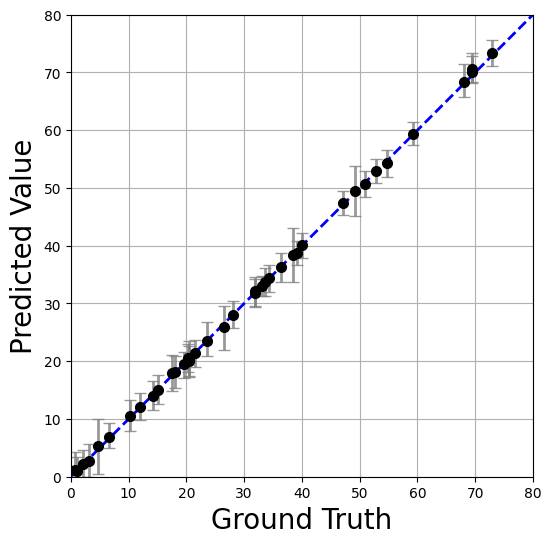

In [24]:
# Plot OOS Prediction Performance
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot([0, 80], [0, 80], "b--", lw=2)

y_err1, y_err2 = median - q1, q2 - median
y_err = torch.cat((y_err1.unsqueeze(0), y_err2.unsqueeze(0)), dim=0).squeeze(-1)
markers, caps, bars = ax.errorbar(
    test_Y.squeeze(-1).cpu().numpy(),
    median.squeeze(-1).cpu().numpy(),
    yerr=y_err.cpu().numpy(),
    fmt=".",
    capsize=4,
    elinewidth=2.0,
    ms=14,
    c="k",
    ecolor="gray",
)
ax.set_xlim([0, 80])
ax.set_ylim([0, 80])
[bar.set_alpha(0.8) for bar in bars]
[cap.set_alpha(0.8) for cap in caps]
ax.set_xlabel("Ground Truth", fontsize=20)
ax.set_ylabel("Predicted Value", fontsize=20)
ax.set_aspect("equal")
ax.grid(True)

Finally, let's inspect the lengthscales from our final model since we expect
that only the first two parameters (0 and 1) to be identified as important by
the SAASBO model. This is confirmed below since the lengthscales for the first
two parameters are small while the other lengthscales are large.

In [25]:
# Inspect Final Model Lengthscales
median_lengthscales = gp.median_lengthscale
for i in median_lengthscales.argsort()[:10]:
    print(f"Parameter{i:2}) Median Lengthscale = {median_lengthscales[i].item():.2e}")

Parameter 0) Median Lengthscale = 6.94e-01
Parameter 1) Median Lengthscale = 2.14e+00
Parameter 4) Median Lengthscale = 3.92e+02
Parameter22) Median Lengthscale = 5.11e+02
Parameter10) Median Lengthscale = 5.15e+02
Parameter13) Median Lengthscale = 5.24e+02
Parameter25) Median Lengthscale = 5.32e+02
Parameter19) Median Lengthscale = 5.61e+02
Parameter14) Median Lengthscale = 5.69e+02
Parameter 9) Median Lengthscale = 6.00e+02


## Bite-Sized Tutorials
The tutorials in this section are focused on specific components often
encountered when customizing Bayesian optimization loops.

### Implementing Custom Acquisition Functions
[_Link to Tutorial on BoTorch_](https://botorch.org/docs/tutorials/custom_acquisition/)

In this tutorial, we review how to implement a custom acquisition function using
BoTorch machinery. Specifically, we will be implementing the **Upper**
**Confidence Bound (UCB)** acquisition function. The acquisition function
balances the exploration-exploitation tradeoff by assigning a score of
$\mu + \sqrt{\beta}*\sigma$ if the posterior distribution is normal with mean
$\mu$ and variance $\sigma^2$. BoTorch provides the "analytic" version of this
acquisition function within the `UpperConfidenceBound` class as well as a Monte
carlo version in the `qUpperConfidenceBound` class, allowing for $q$-batches of
size greater than 1. We will implement scalarized versions of both of these in
the cells below.

First, we will implement a scalarized version of the q-UCB acquisition function.
This is particularly useful if we are in a multi-output setting wherein we want
to model the effect of a design on more than one metric. To do this, we will
extend the q-UCB acquisition function to accept a multi-output model and then
perform q-UCB on a scalarized version of the multiple outputs using a weight
vector. Luckily, implementing a custom acquisition function is easy as one only
needs to implement the constructor and a `forward` method.

In [26]:
# Load Dependencies
import math
from typing import Optional

from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.models.model import Model
from botorch.sampling.base import MCSampler
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils import t_batch_mode_transform
from torch import Tensor

In [27]:
# Implement Scalarized Version of q-UCB

class qScalarizedUpperConfidenceBound(MCAcquisitionFunction):
    """
    This class implements a scalarized version of q-UCB, allowing for
    multi-output models.
    """
    def __init__(
            self,
            model: Model,
            beta: Tensor,
            weights: Tensor,
            sampler: Optional[MCSampler] = None,
    ) -> None:
        super(MCAcquisitionFunction, self).__init__(model=model)
        if sampler is None:
            sampler = SobolQMCNormalSampler(sample_shape=torch.Size([512]))
            
        self.sampler = sampler
        self.register_buffer("beta", torch.as_tensor(beta))
        self.register_buffer("weights", torch.as_tensor(weights))

    @t_batch_mode_transform()
    def forward(self, X:Tensor) -> Tensor:
        """
        Evaluate the scalarized qUCB on the candidate set `X`.

        Args:
            X: A `(b) x q x d`-dim Tensor of `(b)` t-batches with `q` `d`-dim
               design points each.

        Returns:
            Tensor: A `(b)`-dim Tensor of Upper Confidence Bound values at the
                given design points `X`.
        """
        posterior = self.model.posterior(X)
        samples = self.get_posterior_samples(posterior)  # n x b x q x o
        scalarized_samples = samples.matmul(self.weights)  # n x b x q
        mean = posterior.mean  # b x q x o
        scalarized_mean = mean.matmul(self.weights)  # b x q
        ucb_samples = (
            scalarized_mean
            + math.sqrt(self.beta * math.pi / 2)
            * (scalarized_samples - scalarized_mean).abs()
        )
        return ucb_samples.max(dim=-1)[0].mean(dim=0)

Notice that the definition of `qScalarizedUpperConfidenceBound` is very close to
the definition of `qUpperConfidenceBound` and only a few extra lines were needed
to accommodate the scalarization of multiple outputs. The
`@t_batch_mode_transform` decorator makes sure that `X` has an explicit t-batch
dimension. We can achieve the same scalarization effect easily using
`ScalarizedPosteriorTransform` (see the end of this tutorial).

Before attempting to connect this custom acquisition function to a Bayesian
optimization loop, the best practice is to test it first. Thus, we will ensure
that it properly evaluates on a compatible multi-output model using a basic
multi-output `SingleTaskGP` model trained with synthetic data.

In [28]:
# Test Custom Acquisition Function
import torch

from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

torch.set_default_dtype(torch.double)

# generate synthetic dataset
X = torch.rand(20, 2)
Y = torch.stack([torch.sin(X[:, 0]), torch.cos(X[:, 1])], -1)

# fit multi-output model
gp = SingleTaskGP(train_X=X, train_Y=Y)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)

# initialize acquisition function
qSUCB = qScalarizedUpperConfidenceBound(gp, beta=0.1,
                                        weights=torch.tensor([0.1, 0.5]))

In [29]:
# evaluate on single q-batch with q=3
qSUCB(torch.rand(3, 2))

tensor([0.5122], grad_fn=<MeanBackward1>)

In [30]:
# batch-evaluate on two q-batches with q=3
qSUCB(torch.rand(2, 3, 2))

tensor([0.5745, 0.5099], grad_fn=<MeanBackward1>)

This acquisition function is able to handle multi-output models and is thus
ready to be incorporated with an optimization loop. Since BoTorch makes it easy
to swap out acquisition functions, we will not demonstrate that here. Instead,
we will look at how to make a scalarized version of analytic UCB (with $q=1$).

This version of analytic UCB will accommodate multi-output models, assuming a
multivariate normal posterior and $q=1$. Notice that this new class,
`ScalarizedUpperConfidenceBound` subclasses `AnalyticAcquisitionFunction` since
we are not implementing a Monte Carlo batch version (as we did previously).
Compared to the Monte Carlo version, rather than using weights on the samples,
we will directly scalarize the mean vector $\boldsymbol{\mu}$ and covariance
matrix $\boldsymbol{\Sigma}$. Then, we will apply standard UCB on the univariate
normal distribution with mean $w^\intercal\boldsymbol{\mu}$ and variance
$w^\intercal\boldsymbol{\Sigma}w$. Finally, we will also specify `expected_q=1`
in the `@t_batch_mode_transform` decorator to ensure that `X` has `q=1`.

In [31]:
# Implement Scalarized Version of Analytic UCB
from botorch.acquisition import AnalyticAcquisitionFunction

class ScalarizedUpperConfidenceBound(AnalyticAcquisitionFunction):
    """
    This class implements a scalarized version of analytic UCB for use with
    multi-output models.
    """
    def __init__(
        self,
        model: Model,
        beta: Tensor,
        weights: Tensor,
        maximize: bool = True,
    ) -> None:
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.register_buffer("beta", torch.as_tensor(beta))
        self.register_buffer("weights", torch.as_tensor(weights))

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X:Tensor) -> Tensor:
        """
        Evaluate the Upper Confidence Bound on the candidate set `X` using
        scalarization.

        Args:
            X: A `(b) x d`-dim Tensor of `(b)` t-batches of `d`-dim design
                points each.
        
        Returns:
            A `(b)`-dim Tensor of Upper Confidence Bound values at the given
                design points `X`.
        """

        self.beta = self.beta.to(X)
        batch_shape = X.shape[:-2]
        posterior = self.model.posterior(X)
        means = posterior.mean.squeeze(dim=-2)  # b x o
        scalarized_mean = means.matmul(self.weights)  # b
        covs = posterior.mvn.covariance_matrix  # b x o x o
        weights = self.weights.view(
            1, -1, 1
        )  # 1 x o x 1 (assume single batch dimension)
        weights = weights.expand(batch_shape + weights.shape[1:])  # b x o x 1
        weights_transpose = weights.permute(0, 2, 1)  # b x 1 x o
        scalarized_variance = torch.bmm(
            weights_transpose, torch.bmm(covs, weights)
        ).view(
            batch_shape
        )  # b
        delta = (self.beta.expand_as(scalarized_mean) * scalarized_variance).sqrt()
        if self.maximize:
            return scalarized_mean + delta
        else:
            return scalarized_mean - delta

Once again, we will test our implementation of scalarized UCB and reuse the
`SingleTaskGP` multi-output model trained on synthetic data from before. Note
that we will pass in an explicit q-batch dimension for consistency, even though
$q=1$.

In [32]:
# initialize acquisition function
SUCB = ScalarizedUpperConfidenceBound(gp, beta=0.1,
                                      weights=torch.tensor([0.1, 0.5]))

In [33]:
# evaluate on a single point
SUCB(torch.rand(1, 2))

tensor([0.5253], grad_fn=<AddBackward0>)

In [34]:
# batch-evaluate on 3 points
SUCB(torch.rand(3, 1, 2))

tensor([0.4296, 0.3640, 0.5512], grad_fn=<AddBackward0>)

As promised, we can use the `ScalarizedPosteriorTransform` class to easily and
automatically handle the scalarization for us. This only requires a couple lines
of code and this class can be used for both the analytic and Monte Carlo
versions.

In [35]:
from botorch.acquisition.objective import ScalarizedPosteriorTransform
from botorch.acquisition.analytic import UpperConfidenceBound

pt = ScalarizedPosteriorTransform(weights=torch.tensor([0.1, 0.5]))
SUCB = UpperConfidenceBound(gp, beta=0.1, posterior_transform=pt)

## Advanced Usage
The tutorials in this section are focused on advanced BoTorch approaches.